In [1]:
!rm -rf improved_wgan_training
!git clone https://github.com/igul222/improved_wgan_training.git
!rm -rf mAP/samples/cifar10/*

Cloning into 'improved_wgan_training'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 172.64 KiB | 858.00 KiB/s, done.
Resolving deltas: 100% (54/54), done.


# GAN scores

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages

Uppercase local vars:
	BATCH_SIZE: 1024
	CRITIC_ITERS: 5
	DIM: 512
	ITERS: 500
	LAMBDA: 0.1
	MODE: gan
iter 312	disc cost	1.18358242512


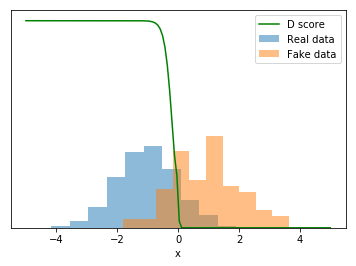

iter 412	disc cost	1.15542316437


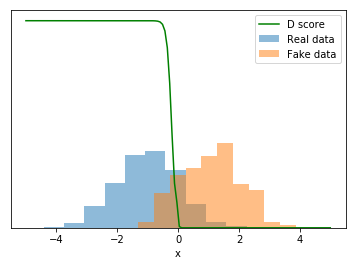

iter 512	disc cost	1.15612053871


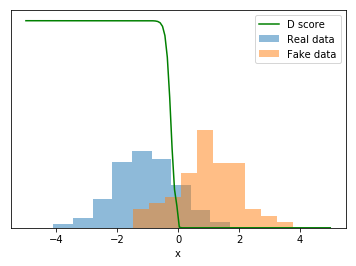

iter 612	disc cost	1.15684843063


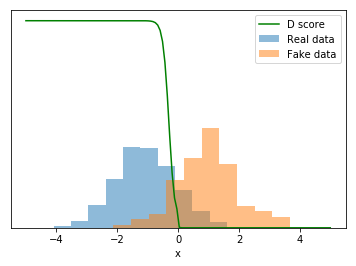

iter 712	disc cost	1.15634763241


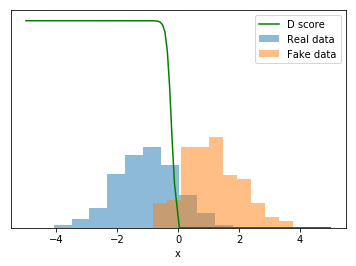

In [3]:
import os, sys
sys.path.append('improved_wgan_training')
import random
import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.datasets

import tflib as lib
import tflib.ops.linear
import tflib.plot

MODE = 'gan' # wgan or wgan-gp
DIM = 512 # Model dimensionality
LAMBDA = .1 # Smaller lambda makes things faster for toy tasks, but isn't
            # necessary if you increase CRITIC_ITERS enough
CRITIC_ITERS = 5 # How many critic iterations per generator iteration
BATCH_SIZE = 1024 # Batch size
ITERS = 500 # how many generator iterations to train for

lib.print_model_settings(locals().copy())

def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear',
        n_in,
        n_out,
        inputs,
        initialization='he'
    )
    output = tf.nn.relu(output)
    return output

def Generator(n_samples, real_data):
    return 1.0 + (1.*tf.random_normal(tf.shape(real_data)))

def Discriminator(inputs):
    output = ReLULayer('Discriminator.1', 1, DIM, inputs)
    output = ReLULayer('Discriminator.2', DIM, DIM, output)
    output = ReLULayer('Discriminator.3', DIM, DIM, output)
    output = ReLULayer('Discriminator.4', DIM, DIM, output)
    output = lib.ops.linear.Linear('Discriminator.5', DIM, 1, output)
    output = tf.sigmoid(output)
    return tf.reshape(output, [-1])

real_data = tf.placeholder(tf.float32, shape=[None, 1])
fake_data = Generator(BATCH_SIZE, real_data)

disc_real = Discriminator(real_data)
disc_fake = Discriminator(fake_data)

# GAN loss
gen_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake, labels=tf.ones_like(disc_fake)))
disc_cost =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake, labels=tf.zeros_like(disc_fake)))
disc_cost += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real, labels=tf.ones_like(disc_real)))

disc_params = lib.params_with_name('Discriminator')
gen_params = lib.params_with_name('Generator')

# Optimizer
disc_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
    disc_cost, 
    var_list=disc_params
)
if len(gen_params) > 0:
    gen_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        gen_cost, 
        var_list=gen_params
    )
else:
    gen_train_op = tf.no_op()

    
def generate_image(true_dist):
    N_POINTS = 128
    RANGE = 5

    points = np.zeros((N_POINTS, 1), dtype='float32')
    points[:,:] = np.linspace(-RANGE, RANGE, N_POINTS)[:,None]
    points = points.reshape((-1,1))
    samples, disc_map = session.run(
        [fake_data, disc_real], 
        feed_dict={real_data:points}
    )
    disc_map = session.run(disc_real, feed_dict={real_data:points})

    plt.clf()

    x = y = np.linspace(-RANGE, RANGE, N_POINTS)

    plt.hist(true_dist[:,0], alpha=0.5, density=True, label='Real data')
    plt.hist(samples[:,0], alpha=0.5, density=True, label='Fake data')
    plt.plot(x,disc_map.reshape(len(x)) / np.max(disc_map), c='green', label='D score')
    plt.xlabel('x')
    plt.yticks([])
    plt.legend()

    plt.show()

# Dataset iterator
def inf_train_gen():
    centers = [
        (-1,0),
    ]
    while True:
        dataset = []
        for i in xrange(BATCH_SIZE):
            point = np.random.randn(2)*1.0
            center = random.choice(centers)
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point[0])
        dataset = np.array(dataset, dtype='float32')
        yield dataset   


# Train loop
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    gen = inf_train_gen()
    for iteration in xrange(ITERS):
        # Train generator
        if iteration > 0:
            _ = session.run(gen_train_op)
        # Train critic
        for i in xrange(CRITIC_ITERS):
            _data = gen.next().reshape(-1,1)
            _disc_cost, _ = session.run(
                [disc_cost, disc_train_op],
                feed_dict={real_data: _data}
            )
        # Write logs and save samples
        lib.plot.plot('disc cost', _disc_cost)
        if iteration % 100 == 99:
            lib.plot.flush()
            generate_image(_data)
            # generate_weight_image(gradval)

        lib.plot.tick()

# WGAN scores

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages

Uppercase local vars:
	BATCH_SIZE: 256
	CRITIC_ITERS: 5
	DIM: 512
	ITERS: 5000
	LAMBDA: 0.1
	MODE: gan
iter 3397	disc cost	-12064539.0


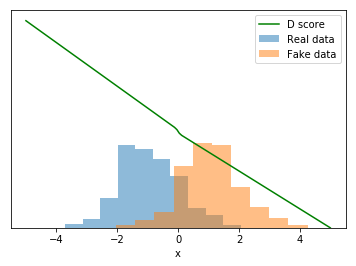

iter 3797	disc cost	-4464198.5


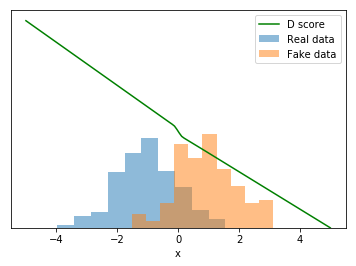

iter 4197	disc cost	-30693186.0


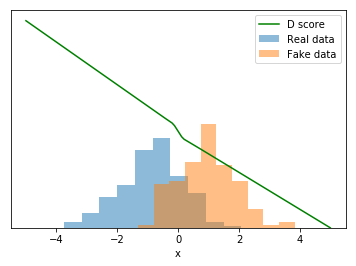

iter 4597	disc cost	-120315240.0


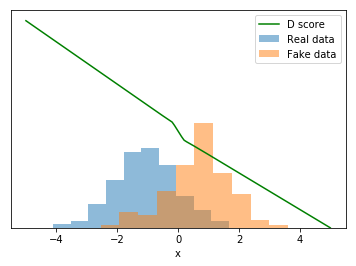

iter 4997	disc cost	-343822912.0


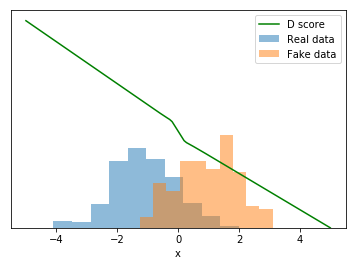

iter 5397	disc cost	-813137024.0


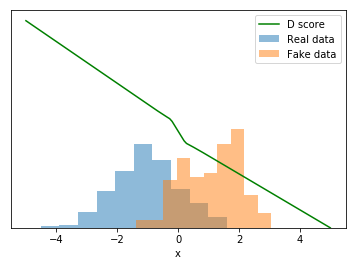

iter 5797	disc cost	-1684044160.0


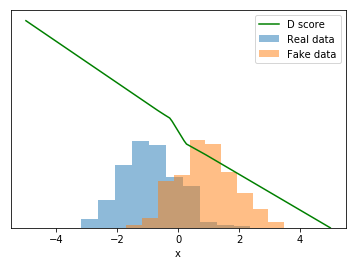

iter 6197	disc cost	-3170514688.0


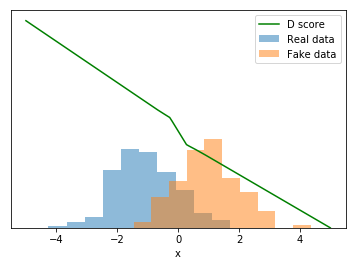

iter 6597	disc cost	-5545768960.0


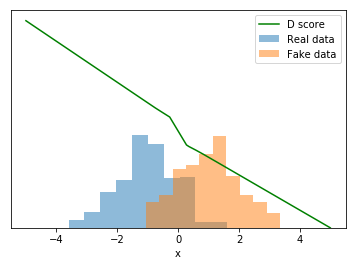

iter 6997	disc cost	-9168304128.0


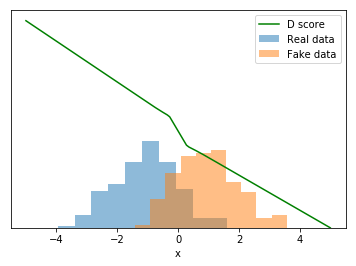

iter 7397	disc cost	-14426332160.0


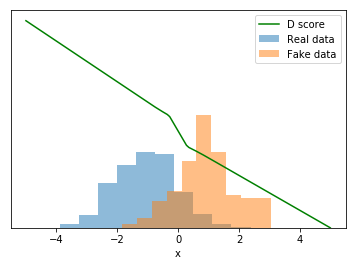

iter 7797	disc cost	-21881757696.0


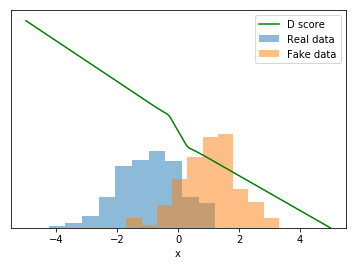

In [6]:
import os, sys
sys.path.append('improved_wgan_training')
import random
import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.datasets

import tflib as lib
import tflib.ops.linear
import tflib.plot

DIM = 512 # Model dimensionality
LAMBDA = .1 # Smaller lambda makes things faster for toy tasks, but isn't
            # necessary if you increase CRITIC_ITERS enough
CRITIC_ITERS = 5 # How many critic iterations per generator iteration
BATCH_SIZE = 256 # Batch size
ITERS = 5000 # how many generator iterations to train for

lib.print_model_settings(locals().copy())

def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear',
        n_in,
        n_out,
        inputs,
        initialization='he'
    )
    output = tf.nn.relu(output)
    return output

def Generator(n_samples, real_data):
    return 1.0 + (1.*tf.random_normal(tf.shape(real_data)))

def Discriminator(inputs):
    output = ReLULayer('Discriminator.1', 1, DIM, inputs)
    output = ReLULayer('Discriminator.2', DIM, DIM, output)
    output = ReLULayer('Discriminator.3', DIM, DIM, output)
    output = ReLULayer('Discriminator.4', DIM, DIM, output)
    output = lib.ops.linear.Linear('Discriminator.5', DIM, 1, output)
    return tf.reshape(output, [-1])

real_data = tf.placeholder(tf.float32, shape=[None, 1])
fake_data = Generator(BATCH_SIZE, real_data)

disc_real = Discriminator(real_data)
disc_fake = Discriminator(fake_data)

# WGAN loss
disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)
gen_cost = -tf.reduce_mean(disc_fake)

disc_params = lib.params_with_name('Discriminator')
gen_params = lib.params_with_name('Generator')

# Optimizer
disc_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
    disc_cost, 
    var_list=disc_params
)
if len(gen_params) > 0:
    gen_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        gen_cost, 
        var_list=gen_params
    )
else:
    gen_train_op = tf.no_op()

# Build an op to do the weight clipping
clip_ops = []
for var in disc_params:
    clip_bounds = [-.01, .01]
    clip_ops.append(
        tf.assign(
            var, 
            tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])
        )
    )
clip_disc_weights = tf.group(*clip_ops)

def generate_image(true_dist):
    N_POINTS = 128
    RANGE = 5

    points = np.zeros((N_POINTS, 1), dtype='float32')
    points[:,:] = np.linspace(-RANGE, RANGE, N_POINTS)[:,None]
    points = points.reshape((-1,1))
    samples, disc_map = session.run(
        [fake_data, disc_real], 
        feed_dict={real_data:points}
    )
    disc_map = session.run(disc_real, feed_dict={real_data:points})

    plt.clf()

    x = y = np.linspace(-RANGE, RANGE, N_POINTS)
    plt.hist(true_dist[:,0], alpha=0.5, density=True, label='Real data')
    plt.hist(samples[:,0], alpha=0.5, density=True, label='Fake data')
    disc_map_toplot = disc_map.reshape(len(x)) - np.min(disc_map)
    disc_map_toplot /= np.max(disc_map_toplot)
    plt.plot(x, disc_map_toplot, c='green', label='D score')
    plt.xlabel('x')
    plt.yticks([])
    plt.legend()

    plt.show()

# Dataset iterator
def inf_train_gen():
    centers = [
        (-1,0),
    ]
    while True:
        dataset = []
        for i in xrange(BATCH_SIZE):
            point = np.random.randn(2)*1.0
            center = random.choice(centers)
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point[0])
        dataset = np.array(dataset, dtype='float32')
        yield dataset   


# Train loop
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    gen = inf_train_gen()
    for iteration in xrange(ITERS):
        # Train generator
        if iteration > 0:
            _ = session.run(gen_train_op)
        # Train critic
        for i in xrange(CRITIC_ITERS):
            _data = gen.next().reshape(-1,1)
            _disc_cost, _ = session.run(
                [disc_cost, disc_train_op],
                feed_dict={real_data: _data}
            )
            if MODE == 'wgan':
                _ = session.run([clip_disc_weights])
        # Write logs and save samples
        lib.plot.plot('disc cost', _disc_cost)
        if iteration % 400 == 399:
            lib.plot.flush()
            generate_image(_data)
            # generate_weight_image(gradval)

        lib.plot.tick()